# What is the Likelihood that American Actors, Singers and Politicians Divorce? - Analyzing Wikipedia Data

In this project, we'll aim to find the likelihood of a divorce among American actors and actresses, singers and politicians and compare the results for each group.

We'll analyze existing data from 14461 profiles on Wikipedia and we'll try to answer the following questions:

1. What is the likelihood of a divorce among US actors? Is there any difference between actors and actresses?
2. Do actors with Academy Award (Oscar) are more likely to divorce?
3. How that rate compare to US politicians and singers?

### Summary of Results

After analyzing the data, the conclusions we reached are:

* The likelihood of a divorce among all US actors is 34,7%
* US actresses are more likely to divorce compared to US actors.
* Academy Award winners are almost two times more likely to get a divorce compared to all US actors.
* US politicians likelihood of a divorce is very low - only 2,8%

For more details, please refer to the the full analysis below.

# Exploring Existing Wikipedia Data

The Wikipedia biography pages have martial statuses and biography for a lot of people, so we can get that information and build our own datasets.

First, we need a list of all the actors, politicians, and singers that we can find in Wikipedia. The easiest way to do this is to look at the [categories on Wikipedia](https://en.wikipedia.org/wiki/Category:Main_topic_classifications) and find out if there are any who would do the job.

It turns out that for our purpose, the following categories will be most appropriate and have the largest amount of pages:

* [American male film actors](https://en.wikipedia.org/wiki/Category:American_male_film_actors): 11 022 total pages
* [American film actresses](https://en.wikipedia.org/wiki/Category:American_film_actresses): 8 224 total pages
* [21st-century American politicians](https://en.wikipedia.org/wiki/Category:21st-century_American_politicians): 11 358 total pages
* [21st-century American singers](https://en.wikipedia.org/wiki/Category:21st-century_American_singers): 5 319 total pages

The next step is to find a way to easily retrieve the necessary data from Wikipeda. There are different approaches - web scraping, using Wikipedia or Wikidata API, Wikimedia dumps. 

If we use Wikidata APi would be best, but the problem is that apart from the names of the spouses, there is no data on the reason for their separation. The cause of a separation can be death or [legal separation](https://en.wikipedia.org/wiki/Legal_separation), and and if we want more accurate results, we need to find another way.

I tried Wikipedia API, but there was something like a bug and for a lot of profiles the data for the spouses was recorded twice and that would be a problem in our analysis later.

Finally, I thought that for our purpose, it would be best to scrape the biography table from every Wikipedia page associated with the categories above.

# Web Scraping Wikipedia Data

In order to find out exactly which pages to scrape, we need to make a request to Wikipedia API and get the pageid of all pages of the relevant category. With the following script, we can extract all pages for any Wikipedia Category, by just changing the name of the category.

```python
import requests

# Wikipedia API has 500 items limit per query, so we are going to make continuing queries and iterate over query results.
def query(request):
    request['action'] = 'query'
    request['format'] = 'json'
    request['list'] = "categorymembers"
    request['cmtitle'] = "Category:21st-century American singers" # name of the category we want to scrape
    request['cmlimit'] = 500
    lastContinue = {}
    while True:
        # Clone original request
        req = request.copy()
        # Modify it with the values returned in the 'continue' section of the last result.
        req.update(lastContinue)
        # Call API
        result = requests.get('https://en.wikipedia.org/w/api.php', params=req).json()
        if 'error' in result:
            raise Error(result['error'])
        if 'warnings' in result:
            print(result['warnings'])
        if 'query' in result:
            yield result['query']
        if 'continue' not in result:
            break
        lastContinue = result['continue']

page_ids = [] # creating a list to store all pageids from the category

for result in query({'generator': 'links'}): # iterating over query results
    for data in result['categorymembers']:
        page_ids.append(data['pageid'])
```
Next piece of code will iterate over all pageids stored in the page_ids list above, scrape some of the data from the biography table (class:infobox) and write it to CSV file. We are doing the same procedure for all of the categories. The result will be 4 datasets to work with. It is important to note, that many profiles does not have a data about the spouses of the person, so **we are scraping only profiles where spouse data is available**.

```python
import numpy as np
import pandas as pd
import csv

with open('us_singers.csv', 'a') as newFile: # appending to blank csv file
    counter = 0
    newFileWriter = csv.writer(newFile)
    none_born = np.array(['None'])
    
    for ids in page_ids:
        page = 'http://en.wikipedia.org/?curid=' + str(ids) # url for the page to scrape
        try:
            infoboxes = pd.read_html(page, index_col=0, attrs={"class":"infobox"})[0] # reading the table with pandas
            name = infoboxes.index.values[0] # name of the page/person
            if 'Born' in infoboxes.index.values:
                born = infoboxes.loc['Born'] # collecting data from the 'Born' row
            else:
                born = pd.Series(none_born)
            if 'Spouse(s)' in infoboxes.index.values:
                spouses = infoboxes.loc['Spouse(s)']  # collecting data from the 'Spouse(s)' row
                
                # Writing the data to CSV file, for actors categories we can add the gender, because we have separate categories
                # for males and females. We can add too 'Political party' for politicians.
                newFileWriter.writerow([name, born.iloc[0], spouses.iloc[0]])  
                counter +=1
                print('{} profiles processed!'.format(counter))
        except Exception as e:
            print("type error: " + str(e))
```

# Exploring the Actors Datasets

Let's first load the actors and actresses datasets and see the first 5 rows of each.

In [1]:
import numpy as np
import pandas as pd

actors_wiki = pd.read_csv('us_actors_wiki.csv', header=None)
actresses_wiki = pd.read_csv('us_actresses_wiki.csv', header=None)

actors_wiki.head()

,0,1,2,3
0,Rob Zabrecky,"Robert ZabreckyJune 2, 1968 (age 50)Burbank, C...",m,Tommi Zabrecky
1,Lee Aaker,"Lee William AakerSeptember 25, 1943 (age 75)Lo...",m,Sharon Ann Hamilton (1969-71) (divorced)
2,Willie Aames,"Albert William UptonJuly 15, 1960 (age 58)Newp...",m,Vicki Weatherman (m. 1979–1984)Maylo McCaslin ...
3,Victor Aaron,"Victor Aaron Ramirez11 September 1956Odessa, T...",m,Eduvina Matta (m. 1974–1984) divorced
4,Bruce Abbott,"Bruce Paul AbbottJuly 28, 1954 (age 64)Portlan...",m,Linda Hamilton(m. 1982; div. 1989)Kathleen Qui...


In [2]:
actresses_wiki.head()

,0,1,2,3
0,Beverly Aadland,"Beverly Elaine AadlandSeptember 16, 1942Hollyw...",f,Maurice Jose de Leon(m. 1961; div. 1964)Joseph...
1,Aaliyah,"Aaliyah Dana HaughtonJanuary 16, 1979Brooklyn,...",f,R. Kelly(m. 1994; ann. 1995)
2,Angela Aames,"Lois Marie TlustosFebruary 27, 1956Pierre, Sou...",f,Mark Haughland (m. 1987)
3,Caroline Aaron,"Caroline Sidney AbadyAugust 7, 1952 (age 66)Ri...",f,James Foreman (m. 1981)
4,Dorothy Abbott,"December 16, 1920Kansas City, Missouri, U.S.",f,Rudy Diaz (m. 1949)


Both datasets have the same columns, so we can combine them into one and add a header. I prefer to use Bash to concatenate the datasets.

```bash
cat us_actors_wiki.csv us_actresses_wiki.csv >> us_actors_combined.csv
```

In [3]:
# Read in the data and add headers
actors = pd.read_csv('us_actors_combined.csv', names=['name', 'born', 'gender','spouses'])
actors.shape

(8296, 4)

After combinig the two datasets, we now have 8296 profiles in our new 'actor' dataset.

In [4]:
actors.tail()

,name,born,gender,spouses
8291,Karen Ziemba,"November 12, 1957 (age 61)St. Joseph, Michigan...",f,Bill Tatum (m. 1984)
8292,Constance Zimmer,"October 11, 1970 (age 48)Seattle, Washington, ...",f,Steve Johnson (m. 1999–2001)[1]Russ Lamoureux ...
8293,Leigh Zimmerman,"Leigh Michelle ZimmermanMadison, Wisconsin",f,Domenick Allen (1993 - present) 1 child
8294,Sheri Moon Zombie,"Sheri Lyn SkurkisSeptember 26, 1970 (age 48)Sa...",f,Rob Zombie (m. 2002)
8295,Vera Zorina,"Eva Brigitta HartwigJanuary 2, 1917Berlin, Ger...",f,George Balanchine(1938–1946; divorced)Goddard ...


Let's explore first the data in 'born' column.

In [5]:
actors['born']

0       Robert ZabreckyJune 2, 1968 (age 50)Burbank, C...
1       Lee William AakerSeptember 25, 1943 (age 75)Lo...
2       Albert William UptonJuly 15, 1960 (age 58)Newp...
3       Victor Aaron Ramirez11 September 1956Odessa, T...
4       Bruce Paul AbbottJuly 28, 1954 (age 64)Portlan...
5       William Alexander AbbottOctober 2, 1897Asbury ...
6       Philip Abbott AlexanderMarch 20, 1924Lincoln, ...
7       Jacob Allen AbelNovember 18, 1987 (age 31)Cant...
8                   June 6, 1898St. Paul, Minnesota, U.S.
9       Murray AbrahamOctober 24, 1939 (age 79)Pittsbu...
10      November 27, 1971 (age 47)Brooklyn, New York C...
11      Jensen Ross AcklesMarch 1, 1978 (age 40)Dallas...
12                     July 29, 1920Chamizal, Texas, U.S.
13      Donald James YarmyApril 13, 1923New York City,...
14           February 26, 1919[1]Brooklyn, New York, U.S.
15      Nicholas Aloysius AdamshockJuly 10, 1931Nantic...
16      Robert Lee AdamsSeptember 20, 1942St. Catharin...
17      Robert

We notice that for every living person, the column records his age as '(age xx)'. It would be useful for our analysis to have the age of the actors, so we can apply a function to all rows in the column 'born', extract the age of the actor and create a new column 'age'.

# Extract Age from the Actors Dataset

Best way to extract the age is to use regular expression and search the text in 'born' column.

In [6]:
import re

def extract_age(text):
    match = re.search( r'\(age.(.+)\)', text) # use regex to match the pattern
    if match:
        age = match.group(1)
    else:
        age = np.NaN # If there is no match, assign numpy NaN value to age
    return age

actors['age'] = actors['born'].apply(extract_age) # function apply and create new column 'age'

No we can explore our new 'age' column to look if we need to do some additional cleaning of the data

In [7]:
actors['age'].value_counts() # print the diffrent values in 'age' column

48                                                                                         132
47                                                                                         125
56                                                                                         106
57                                                                                         104
46                                                                                         101
49                                                                                         100
43                                                                                          99
53                                                                                          95
50                                                                                          95
62                                                                                          94
55                                                

We can notice that in some of the results, our regex did not work properly, so we need to do some additional cleaning. We can split the text first by ')', then by space and '-' to extract the first two or 3 digits from the 'age' column. For any NaN values we will assign zero and convert the column to int64 type.

In [8]:
# Split the text by ')', '–' and space
actors['age'] = (actors['age']
                .str.split(')', n=1, expand=True)[0]
                .str.split('–', n=1, expand=True)[0]
                .str.split(n=1, expand=True)[0]
                )

actors['age'] = actors['age'].fillna(0).astype(int) # fill NaN values with 0 and convert to integers
actors['age'].value_counts()

0      3890
48      133
47      126
56      106
57      105
46      103
43      102
49      100
62       99
50       96
53       95
54       95
40       94
55       94
39       92
38       92
52       91
51       90
59       90
44       89
42       88
41       88
67       87
60       86
58       84
37       83
45       83
69       83
71       82
64       82
       ... 
33       33
88       30
84       29
89       29
31       29
90       28
86       28
30       24
92       18
91       17
93       15
94       13
95       10
29        9
28        8
26        7
27        7
96        7
99        5
25        5
24        3
97        3
100       3
22        2
102       2
105       1
101       1
104       1
23        1
113       1
Name: age, Length: 84, dtype: int64

'Age' column now looks clean, we also converted the NaN values to zero. 

# Extract Divorce Count from the Actors Dataset

Next step is to explore the 'spouses' column and tо think about how we can interpret the data.

In [9]:
actors['spouses']

0                                          Tommi Zabrecky
1                Sharon Ann Hamilton (1969-71) (divorced)
2       Vicki Weatherman (m. 1979–1984)Maylo McCaslin ...
3                   Eduvina Matta (m. 1974–1984) divorced
4       Linda Hamilton(m. 1982; div. 1989)Kathleen Qui...
5                                   Betty Smith (m. 1918)
6                            Jane Dufrayne (m. 1950–1998)
7                                    Allie Wood (m. 2013)
8                  Marietta Bitter (1926-1979; her death)
9                                   Kate Hannan (m. 1962)
10                              Kiersten Warren (m. 2005)
11                               Danneel Harris (m. 2010)
12                        Jeanine Cohen (m. 1945-19??)[1]
13      Adelaide Efantis(m. 1947; div. 1960)Dorothy Br...
14                              Margot Feinberg (m. 1957)
15                       Carol Nugent(m. 1959; div. 1965)
16                                  Diane Adams (m. 1968)
17            

In [10]:
actors['spouses'][4]

'Linda Hamilton(m.\xa01982; div.\xa01989)Kathleen Quinlan (m.\xa01994)'

In [11]:
actors['spouses'][8289]

'Mark Pinter (1987-2010; divorced); 2 children Michael Crouch (1983-1986; divorced); 1 child)'

There is a pattern in the data, every divorce is mentioned either as 'div.' or 'divorced'.

Now is the time to specify something **important** too. In the data, apart from divorce, the '**legal separation**' is also mentioned. A [legal separation](https://en.wikipedia.org/wiki/Legal_separation) occurs when a married couple decides to live apart as unmarried, rather than go through a divorce.<br>
For our analysis, I think we should consider the separation the same thing as divorce. The separation is mentioned as 'sep.' or 'separated' in 'spouses' data
We'll write a function and apply it to 'spouse' column to count the number of occurrences of the strings (div., divorced, sep., separated) and append a new column 'divorce_count' with the results.


In [12]:
def divorce_count(data):
    data = str(data)
    counter = 0
    substr = ['divorced', 'div.', 'sep.', 'separated'] # substrings to search for
    for s in substr:
        counter += data.count(s) # count the number of occurrences of the substring
    return counter

# Apply 'divorce_count' func to 'spouse' column and append new column 'divorce_count' with the results
actors['divorce_count'] = actors['spouses'].apply(divorce_count)

actors['divorce_count'].value_counts() # display unique values counts for 'divorce_count' column

0    5415
1    1873
2     680
3     235
4      69
5      14
6       6
7       4
Name: divorce_count, dtype: int64

We successfully counted the divorces and the separations and appended a new column 'divorce_count' with the results.

# What is the Likelihood of a Divorce among All American Actors?

Now that we have all the 'divorce_count' values, we can calculate and visualize the percentage of actors without divorce and those with one or more divorce.

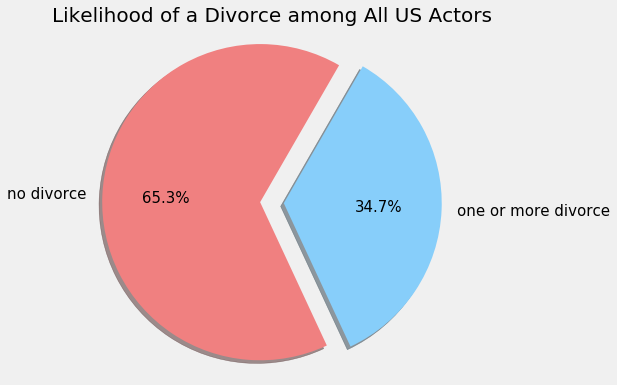

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style as style

# Convert 'divorce_count' values to list and then assign the first value to 'no divorce' part of the pie
# and the sum of the next values to 'one or more divorce' part of the pie.
divorce_value_counts = actors['divorce_count'].value_counts().tolist() 
 
# Define function to plot a pie chart with two arguments - divorce_value_counts list, title (string) and angle(int)
def pie_chart(divorce_value_counts, title, angle):
    style.use('fivethirtyeight')
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    plt.pie([divorce_value_counts[0], sum(divorce_value_counts[1:])], explode=(0, 0.15), labels=['no divorce', 'one or more divorce'], colors=['lightcoral', 'lightskyblue'],
        autopct='%1.1f%%', shadow=True, startangle=angle, textprops={'fontsize': 15})
    plt.axis('equal')
    ax.set_title(title, fontsize=20)
    plt.show()

pie_chart(divorce_value_counts,'Likelihood of a Divorce among All US Actors',60)


From the chart, we can conclude that all actors(including actresses) with **one or more divorce account for 34,7%**. Since we have gender information in the dataset, we can make an comparison of the divorce rate between actors and actresses.

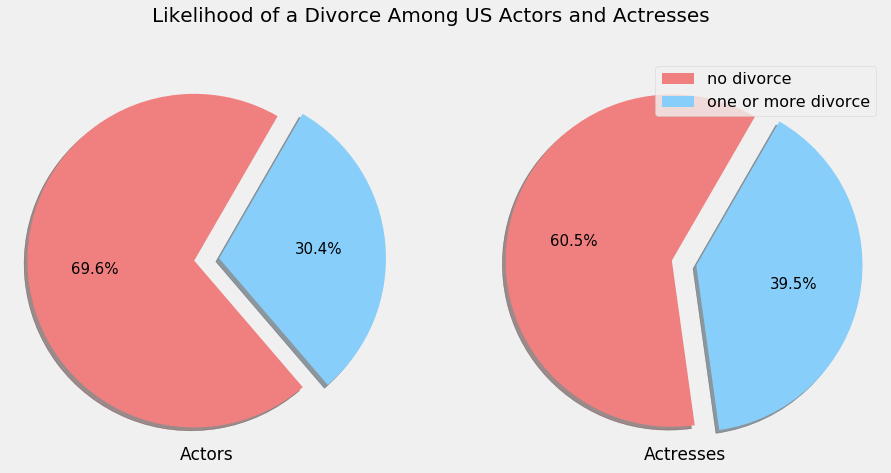

In [14]:
# Select value counts for 'divorce_count' by filtering by gender(m or f)
first_divorce_value_counts = actors.loc[actors['gender'] == 'm','divorce_count'].value_counts().tolist()
second_divorce_value_counts = actors.loc[actors['gender'] == 'f','divorce_count'].value_counts().tolist()

# Define function to plot two pie charts with 4 arguments - figure title, sublot1 title, sublot2 title, startangle
def two_pie_charts(title, subplot1, subplot2, angle):
    labels = 'no divorce', 'one or more divorce'
    sizes_m = [first_divorce_value_counts[0], sum(first_divorce_value_counts[1:])]
    sizes_f = [second_divorce_value_counts[0], sum(second_divorce_value_counts[1:])]
    colors = ['lightcoral', 'lightskyblue']
    explode = (0, 0.15)  # explode 2nd slice
 
    # Plot two pie charts with the diffrent values for male and female('m' and 'f')
    style.use('fivethirtyeight')
    fig = plt.figure(figsize=(14, 7))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    fig.suptitle(title, fontsize=20)
    ax1.pie(sizes_m, explode=explode, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=angle, textprops={'fontsize': 15})
    ax1.axis('equal')
    ax1.set_title(subplot1, fontsize=17, y=0)

    ax2.pie(sizes_f, explode=explode, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=angle, textprops={'fontsize': 15})
    ax2.axis('equal')
    ax2.set_title(subplot2, fontsize=17, y=0)
    plt.legend(loc="best", labels=labels, prop={'size': 16})

    plt.show()

two_pie_charts('Likelihood of a Divorce Among US Actors and Actresses','Actors','Actresses',60)

It is clear from the charts that **actresses are more likely to divorce than actors** (39,5% vs 30,4%). We can complete our analysis for the actors dataset with a histogram for the age distribution among the profiles with available age.

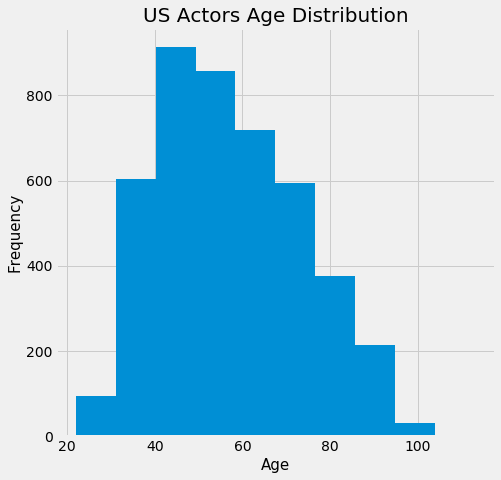

The average age is: 57.5 years


In [15]:
# Define function to plot age distribution histogram and print the mean age
def age_dist(dataset,title):
    style.use('fivethirtyeight')
    ax = dataset['age'].loc[dataset['age'] > 0].plot.hist(figsize=(7,7)) # select only rows, where age is available (age > 0)
    ax.set_xlabel('Age', fontsize=15)
    ax.set_ylabel('Frequency', fontsize=15)
    ax.set_title(title, fontsize=20)
    plt.show()

    # Print and calculate the mean age
    print('The average age is: {0:.1f} years'.format(dataset['age'].loc[dataset['age'] > 0].mean()))

age_dist(actors,'US Actors Age Distribution')

# Who are the actors and actresses with the most divorces?

Let's list top 10 actors and actresses with highest number of divorces.

In [16]:
actors_sorted = (actors[['name','gender','age','divorce_count']]
                 .sort_values(by=['divorce_count'], ascending=False)
                 .set_index('name')
                )
actors_sorted.head(10)

,gender,age,divorce_count
name,,,
DameElizabeth TaylorDBE,f,0,7
Lana Turner,f,0,7
Georgia Holt,f,92,7
Zsa Zsa Gabor,f,0,7
Lillian Roth,f,0,6
Ruth Warrick,f,0,6
Douglas Fowley,m,0,6
Hedy Lamarr,f,0,6
Mickey Rooney,m,0,6


What about only the living actors and actresses?

In [17]:
actors_sorted = (actors.loc[actors['age'] > 0,['name','gender','age','divorce_count']]
                 .sort_values(by=['divorce_count'], ascending=False)
                 .set_index('name')
                )
actors_sorted.head(10)

,gender,age,divorce_count
name,,,
Georgia Holt,f,92,7
Billy Bob Thornton,m,63,5
Lorenzo Lamas,m,60,5
Arlene Dahl,f,93,5
Sue Lyon,f,72,5
Vera Miles,f,89,4
Steven Bauer,m,62,4
Nia Peeples,f,57,4
Christopher Lloyd,m,80,4


# Do Actors and Actresses with Academy Awards (Oscars) Divorce More Often?

It would be good if we could also analyze part of the actors who are more famous and have some honors. I suspect that divorces should be a more frequent phenomenon among them, as they are better known and supposed to work more. We can assume that careers are often at the expense of personal life.

To do this, we'll scrape from Wikipedia all the actors and actresses who have won at least one Oscar for Best Actor or Best Actress from the following Wikipedia Categories:
* [Best Actor Academy Award winners](https://en.wikipedia.org/wiki/Category:Best_Actor_Academy_Award_winners)
* [Best Actress Academy Award winners](https://en.wikipedia.org/wiki/Category:Best_Actress_Academy_Award_winners)

Then, we'll search our actors dataframe for the names in the categories above and create a new dataframe only with actors and actresses with Academy Award.

In [18]:
import requests

page = 'https://en.wikipedia.org/w/api.php' # Wikipedia API
categories = ['Category:Best Actor Academy Award winners'
              ,'Category:Best Actress Academy Award winners' ] # categories to scrape from
award_winners = [] # blank list to store the results

for category in categories:
    params = {
    'action': "query",
    'list': "categorymembers",
    'cmtitle': category,
    'cmlimit': 500,
    'format': "json"
     }

    result = requests.get(url=page, params=params) # connect to Wikipedia API with specified parameters 
    data = result.json()

    for link in data['query']['categorymembers']:
        award_winners.append(link['title']) # get the title from every link and append to the blank list

# Create new Dataframe
award_winners_df = pd.DataFrame(columns = ['name','born','gender','spouses','age','divorce_count'])

# Append every row that matches the name from award_winners list and 'actors' dataset to the new dataframe
for name in award_winners:
    row = actors.loc[actors['name'].str.contains(name)]
    award_winners_df = award_winners_df.append(row)
    
award_winners_df

,name,born,gender,spouses,age,divorce_count
9,F. Murray Abraham,"Murray AbrahamOctober 24, 1939 (age 79)Pittsbu...",m,Kate Hannan (m. 1962),79,0
26,Casey Affleck,"Caleb Casey McGuire Affleck-BoldtAugust 12, 19...",m,Summer Phoenix(m. 2006; div. 2017),43,1
233,Lionel Barrymore,"Lionel Herbert BlytheApril 28, 1878Philadelphi...",m,Doris Rankin (1904–1922; divorced; 2 children)...,0,1
259,Warner Baxter,"March 29, 1889Columbus, Ohio, U.S.",m,Viola Caldwell (1911-1913)Winifred Bryson (191...,0,0
282,Wallace Beery,"Wallace Fitzgerald BeeryApril 1, 1885Clay Coun...",m,Gloria Swanson(m. 1916; div. 1918)Rita Gilman(...,0,2
390,Humphrey Bogart,"Humphrey DeForest BogartDecember 25, 1899New Y...",m,Helen Menken(m. 1926; div. 1927)Mary Philips(m...,0,3
409,Ernest Borgnine,"Ermes Effron BorgninoJanuary 24, 1917Hamden, C...",m,Rhoda Kemins(m. 1949; div. 1958)Katy Jurado(m....,0,4
443,Marlon Brando,"Marlon Brando Jr.April 3, 1924Omaha, Nebraska,...",m,Anna Kashfi(m. 1957; div. 1959)Movita Castaned...,0,3
464,Jeff Bridges,"Jeffrey Leon BridgesDecember 4, 1949 (age 69)L...",m,Susan Geston (m. 1977),69,0
588,Nicolas Cage,"Nicolas Kim CoppolaJanuary 7, 1964 (age 54)Lon...",m,Patricia Arquette(m. 1995; div. 2001)Lisa Mari...,54,3


We were able to make a new dataframe with 106 names that won at least one Oscar. Now we can find the percentage of actors and actresses with Academy Award with at least one divorce

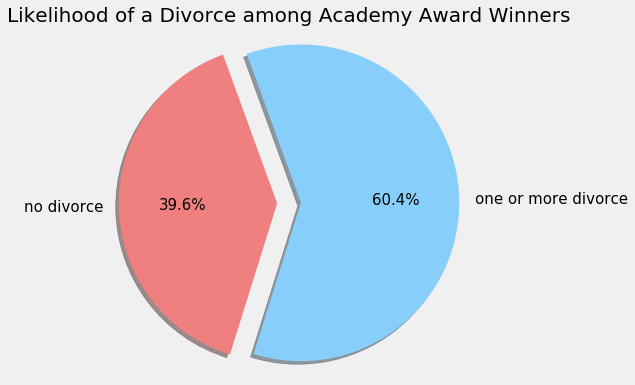

In [19]:
divorce_value_counts = award_winners_df['divorce_count'].value_counts().tolist()

# Use the defined function above to plot the pie chart
pie_chart(divorce_value_counts,'Likelihood of a Divorce among Academy Award Winners',110)

The pie chart show us that the **likelihood of a divorce among actors with Academy Award is 60.4%**.<br>
We can now compare this result with all actors using a bar chart.

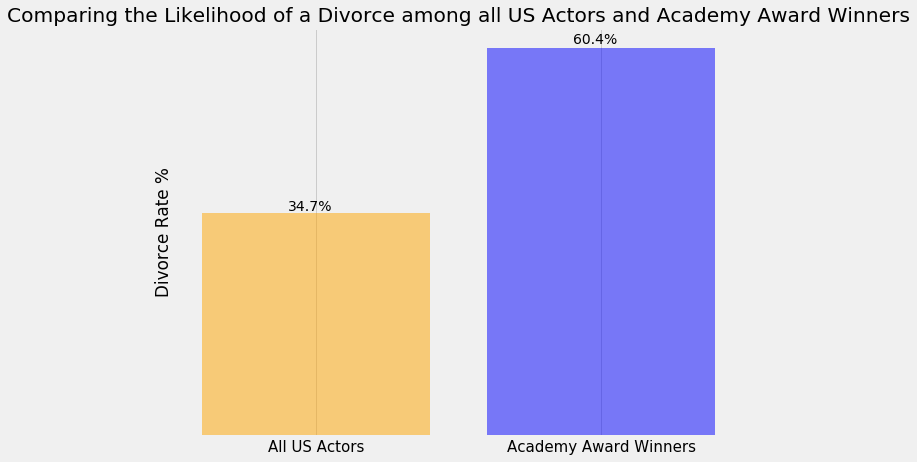

In [20]:
objects = ('All US Actors', 'Academy Award Winners')
y_pos = np.arange(len(objects))
performance = [34.7, 60.4]

# Plot
style.use('fivethirtyeight')
fig = plt.figure(figsize=(9,7))
plt.bar(y_pos, performance, align='center', alpha=0.5, color=['orange', 'blue'])
plt.xticks(y_pos, objects, fontsize=15)
plt.ylabel('Divorce Rate %')
plt.text(-0.1,35,'34.7%')
plt.text(0.9,61,'60.4%')
plt.yticks([]) # hide 'y' ticks
plt.title('Comparing the Likelihood of a Divorce among all US Actors and Academy Award Winners')

plt.show()

Now we can confirm our hypothesis that **US Actors and Actresses with Academy Awards** are **more likely to divorce**(almost two times more likely) compared to all US actors and actresses.

# Preparing Politicians and SIngers Datasets 

The same analysis we have done above can also be made for politicians and singers datasets. Let's read the both datasets and explore them.

In [21]:
politicians = pd.read_csv('us_politicians_wiki.csv', names=['name', 'born', 'party','spouses'], header=None)
singers = pd.read_csv('us_singers_wiki.csv', header=None, names=['name', 'born','spouses'])

print(politicians.shape)
politicians.head(10)

(5737, 4)


,name,born,party,spouses
0,Douglas C. Aagard,October 19,Republican,Denise
1,Sam Aanestad,"Samuel Mark AanestadJuly 16, 1946Bismarck, Nor...",Republican,Susan Aanestad
2,Watkins Abbitt Jr.,"Watkins Moorman Abbitt Jr.October 20, 1944 (ag...",Independent,Madeline I. Ganley
3,Greg Abbott,"Gregory Wayne AbbottNovember 13, 1957 (age 61)...",Republican,Cecilia Phalen (m. 1981)
4,Jim Abeler,"May 18, 1954 (age 64)Minneapolis, Minnesota, U.S.",Republican Party of Minnesota,Barb
5,Neil Abercrombie,"June 26, 1938 (age 80)Buffalo, New York, U.S.",Democratic,Nancie Caraway (m. 1981)
6,Thomas Abinanti,"1946/1947 (age 71–72)New York City, New York, ...",Democratic,Janet Longo
7,Mark Thorpe Abraham,"November 11, 1953 (age 65)",Republican,Gina Abraham
8,Ralph Abraham,"Ralph Lee Abraham Jr.September 16, 1954 (age 6...",Republican,Dianne Abraham (m. 1977)
9,Spencer Abraham,"Edward Spencer AbrahamJune 12, 1952 (age 66)Ea...",Republican,Jane Abraham


Our politicians dataset has 5737 records. These is no way we can split the data by gender but instead of that, we have a political pary ('party') column scraped from the Wikipedia biography page.

In [22]:
print(singers.shape)
singers.head(10)

(428, 3)


,name,born,spouses
0,Aaliyah,"Aaliyah Dana HaughtonJanuary 16, 1979Brooklyn,...",R. Kelly(m. 1994; ann. 1995)
1,Paula Abdul,"Paula Julie AbdulJune 19, 1962 (age 56)San Fer...",Emilio Estevez(m. 1992; div. 1994) Brad Becker...
2,Amy Adams,"Amy Lou AdamsAugust 20, 1974 (age 44)Vicenza, ...",Darren Le Gallo (m. 2015)
3,Pearl Aday,1975 (age 42–43),Scott Ian
4,Titilayo Adedokun,Titilayo Rachel Adedokun1973 (age 44–45)Nashvi...,Ruediger Helm
5,Dianna Agron,"Dianna Elise AgronApril 30, 1986 (age 32)Savan...",Winston Marshall (m. 2016)
6,Christina Aguilera,"Christina María AguileraDecember 18, 1980 (age...",Jordan Bartman(m. 2005; div. 2011)
7,Tatyana Ali,"Tatyana Marisol AliJanuary 24, 1979 (age 39)No...",Vaughn Rasberry (m. 2016)
8,Keith Andes,"John Charles AndesJuly 12, 1920Ocean City, New...",Jean Alice Cotton (m. 1946–1961) (divorced) 2 ...
9,Angelyne,"Ronia Tamar GoldbergOctober 2, 1950 (age 68)Po...",Michael Strauss(m. 1968; div. 1969)


The US singers dataset has only 428 recorda. The sample size is not big, but I think it is enough for our goals and we can get some general conclusions.

We can extract the age and the divorce count from politicians and singers dataframes the same way we did it with the actors dataset and append new columns 'age' and 'divorce_count'.

In [23]:
dataframes = [politicians, singers]

for df in dataframes:
    df['age'] = df['born'].apply(extract_age) # apply extract_age function and create new column 'age' for both datasets
    # Additional cleaning of 'age' column
    df['age'] = (df['age']
                .str.split(')', n=1, expand=True)[0]
                .str.split('–', n=1, expand=True)[0]
                .str.split(n=1, expand=True)[0]
                )
    df['age'] = df['age'].fillna(0).astype(int) # fill NaN values with 0 and convert to integers
    
    # Apply 'divorce_count' function to 'spouse' column and append new column 'divorce_count' with the results
    df['divorce_count'] = df['spouses'].apply(divorce_count)

In [24]:
politicians.head(10)

,name,born,party,spouses,age,divorce_count
0,Douglas C. Aagard,October 19,Republican,Denise,0,0
1,Sam Aanestad,"Samuel Mark AanestadJuly 16, 1946Bismarck, Nor...",Republican,Susan Aanestad,0,0
2,Watkins Abbitt Jr.,"Watkins Moorman Abbitt Jr.October 20, 1944 (ag...",Independent,Madeline I. Ganley,74,0
3,Greg Abbott,"Gregory Wayne AbbottNovember 13, 1957 (age 61)...",Republican,Cecilia Phalen (m. 1981),61,0
4,Jim Abeler,"May 18, 1954 (age 64)Minneapolis, Minnesota, U.S.",Republican Party of Minnesota,Barb,64,0
5,Neil Abercrombie,"June 26, 1938 (age 80)Buffalo, New York, U.S.",Democratic,Nancie Caraway (m. 1981),80,0
6,Thomas Abinanti,"1946/1947 (age 71–72)New York City, New York, ...",Democratic,Janet Longo,71,0
7,Mark Thorpe Abraham,"November 11, 1953 (age 65)",Republican,Gina Abraham,65,0
8,Ralph Abraham,"Ralph Lee Abraham Jr.September 16, 1954 (age 6...",Republican,Dianne Abraham (m. 1977),64,0
9,Spencer Abraham,"Edward Spencer AbrahamJune 12, 1952 (age 66)Ea...",Republican,Jane Abraham,66,0


In [25]:
singers.head(10)

,name,born,spouses,age,divorce_count
0,Aaliyah,"Aaliyah Dana HaughtonJanuary 16, 1979Brooklyn,...",R. Kelly(m. 1994; ann. 1995),0,0
1,Paula Abdul,"Paula Julie AbdulJune 19, 1962 (age 56)San Fer...",Emilio Estevez(m. 1992; div. 1994) Brad Becker...,56,2
2,Amy Adams,"Amy Lou AdamsAugust 20, 1974 (age 44)Vicenza, ...",Darren Le Gallo (m. 2015),44,0
3,Pearl Aday,1975 (age 42–43),Scott Ian,42,0
4,Titilayo Adedokun,Titilayo Rachel Adedokun1973 (age 44–45)Nashvi...,Ruediger Helm,44,0
5,Dianna Agron,"Dianna Elise AgronApril 30, 1986 (age 32)Savan...",Winston Marshall (m. 2016),32,0
6,Christina Aguilera,"Christina María AguileraDecember 18, 1980 (age...",Jordan Bartman(m. 2005; div. 2011),38,1
7,Tatyana Ali,"Tatyana Marisol AliJanuary 24, 1979 (age 39)No...",Vaughn Rasberry (m. 2016),39,0
8,Keith Andes,"John Charles AndesJuly 12, 1920Ocean City, New...",Jean Alice Cotton (m. 1946–1961) (divorced) 2 ...,0,2
9,Angelyne,"Ronia Tamar GoldbergOctober 2, 1950 (age 68)Po...",Michael Strauss(m. 1968; div. 1969),68,1


Our dataframes looks good and we can continue our analysis by calculating how many US politicians and US singers have one or more divorces.

# What is the Likelihood of a Divorce Among American Politicians?

Lets's visualise the likelihood of a divorce among US politicians.

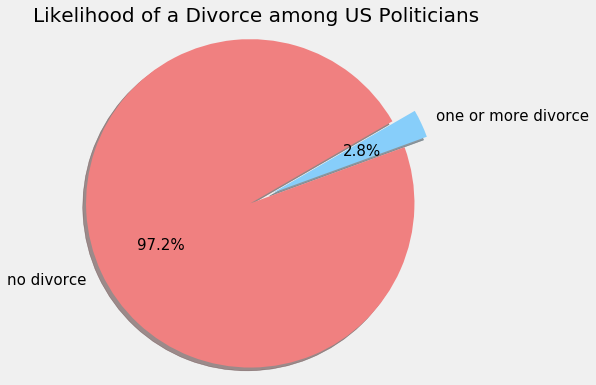

In [26]:
divorce_value_counts = politicians['divorce_count'].value_counts().tolist()

# Use the defined function above to plot the pie chart
pie_chart(divorce_value_counts,'Likelihood of a Divorce among US Politicians',30)

The pie chart show us that the **likelihood of a divorce among US politicians is only 2.8%**! It's almost dozen times lower than US actors! I expected to get a lower rate, but not so much.

We can continue the analysis by visualise politicians likelihood of a divorce for the two major political parties - Democratic and Republican

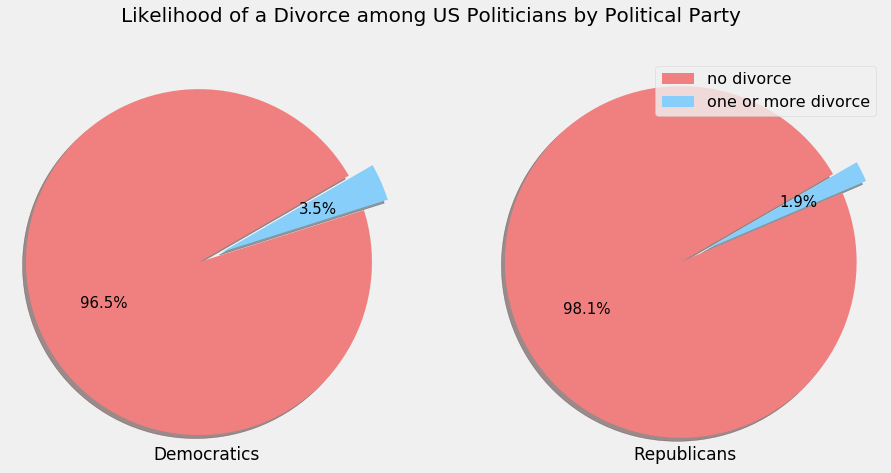

In [27]:
# Select value counts for 'divorce_count' by filtering by party(Democratic or Republican)
first_divorce_value_counts = politicians.loc[politicians['party'] == 'Democratic','divorce_count'].value_counts().tolist()
second_divorce_value_counts = politicians.loc[politicians['party'] == 'Republican','divorce_count'].value_counts().tolist()

# Use the defined function above
two_pie_charts('Likelihood of a Divorce among US Politicians by Political Party','Democratics','Republicans',30)

I do not think we have to make any conclusions here, there is not so much difference between the two parties

To finish our US politicians analysis, let's plot the age distribution and the mean age.

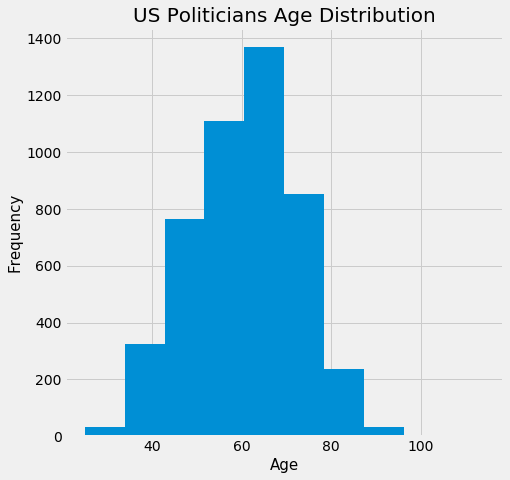

The average age is: 60.6 years


In [28]:
# Use the defined function above to plot the histogram
age_dist(politicians,'US Politicians Age Distribution')

# What is the Likelihood of a Divorce Among American Singers?

Before we compare the results between the different dataframes, we'll also plot the likelihood of a divorce among US singers.

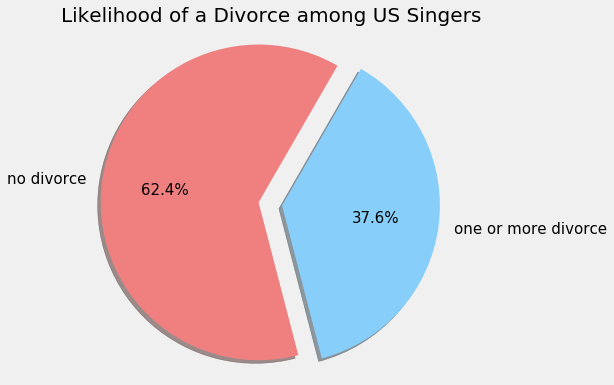

In [29]:
divorce_value_counts = singers['divorce_count'].value_counts().tolist()

# Use the defined function above to plot the pie chart
pie_chart(divorce_value_counts,'Likelihood of a Divorce among US Singers',60)

We can see from the chart that **37.6% among US singers have one or more divorce**.

Let's plot the age distribution and mean age.

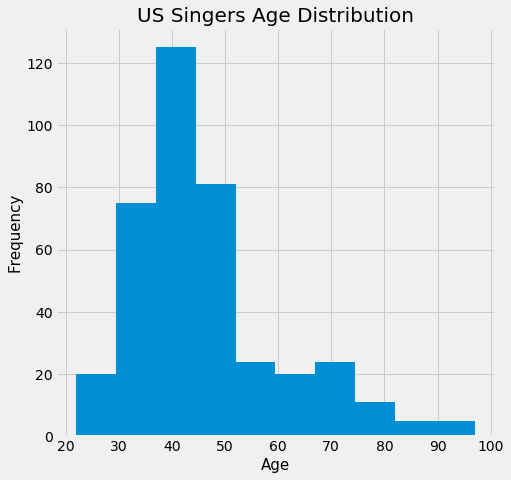

The average age is: 45.8 years


In [30]:
# Use the defined function above to plot the histogram
age_dist(singers,'US Singers Age Distribution')

# Comparing the Likelihood of a Divorce among US Actors, Politicians and Singers

Now, we'll plot a bar chart to compare the divorce rates among US actors, US politicians and US singers.

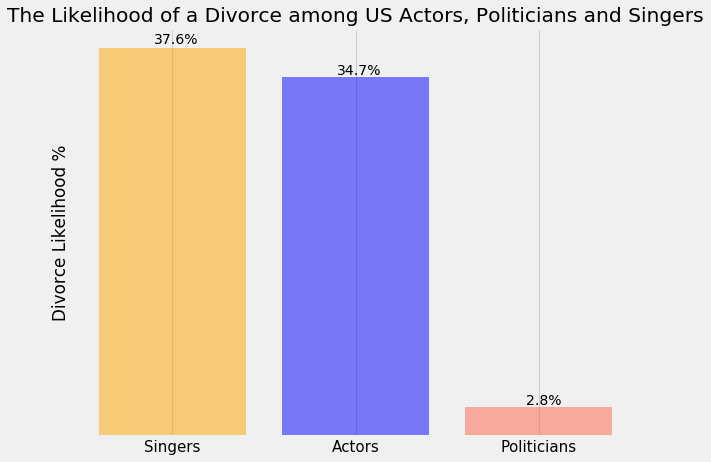

In [31]:
objects = ('Singers', 'Actors', 'Politicians')
y_pos = np.arange(len(objects))
performance = [37.6, 34.7, 2.8]

style.use('fivethirtyeight')
fig = plt.figure(figsize=(9,7))
plt.bar(y_pos, performance, align='center', alpha=0.5, color=['orange', 'blue', 'tomato'])
plt.xticks(y_pos, objects, fontsize=15)
plt.ylabel('Divorce Likelihood %')
plt.text(-0.1,38,'37.6%')
plt.text(0.9,35,'34.7%')
plt.text(1.93,3,'2.8%')
plt.yticks([])
#plt.gca().axes.get_yaxis().set_visible(False)
plt.title('The Likelihood of a Divorce among US Actors, Politicians and Singers')
 
plt.show()

As we can see, the highest is the likelihood of the **US singers - 37,6%** divorcing, followed by **US actors with 34,7%** and the lowest is the percentage of **US politicians - 2.8%**.<br>
Given the small sample size we have for the singers dataset (428 records for singers vs 8296 records for actors and 5737 for politicians), I think we can not make a firm conclusion that the US singers are more likely to divorce than the US actors. I would interpret the results that likelihood of a divorce among US singers and US actors is the same and it is around 35%.

Let's plot the age distribution and the average age of all datasets.

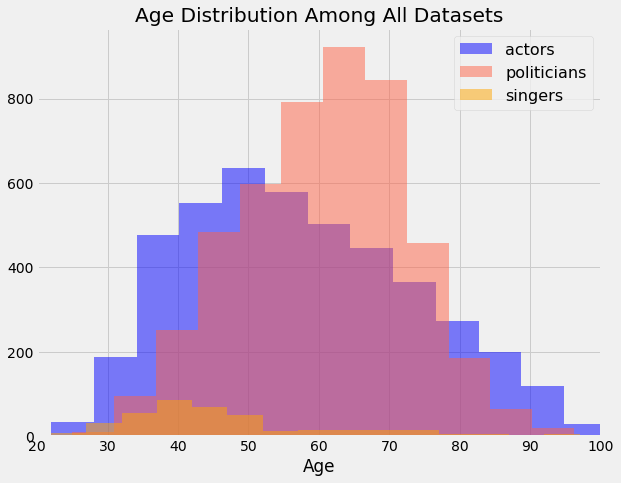

Average age for US actors: 57.5 years
Average age for US politicians: 60.6 years
Average age for US singers: 45.8 years


In [32]:
bins = 15
x = actors.loc[actors['age'] > 0, 'age']
y = politicians.loc[politicians['age'] > 0, 'age']
z = singers.loc[singers['age'] > 0, 'age']

style.use('fivethirtyeight')
fig = plt.figure(figsize=(9,7))
plt.hist(x, bins, alpha=0.5, label='actors', color='blue')
plt.hist(y, bins, alpha=0.5, label='politicians', color='tomato')
plt.hist(z, bins, alpha=0.5, label='singers', color='orange')
plt.xlim(20, 100)
plt.xlabel('Age')
plt.title('Age Distribution Among All Datasets')
plt.legend(loc='upper right', prop={'size': 16})
plt.show()

# create dictionary with all datasets and their names
datasets = {
            'actors': actors,
            'politicians': politicians,
            'singers': singers
        }

for k,v in datasets.items():
    print('Average age for US {name}: {mean:2.1f} years'.format(name=k,mean=v['age'].loc[v['age'] > 0].mean())) # iterate and print from dict

The only interesting conclusion we can make from the graph above is that the average age of the singers is about 10-12 years lower than that of actors and politicians.

# Conclusion

In this project, we analysed existing data from 14461 profiles on Wikipedia to find the likelihood of a divorce among US Actors and actresses, US politicians and US singers.

We reached the following solid conclusions:

* The likelihood of a divorce among all US actors is 34,7%
* US actresses are more likely to divorce compared to US actors.
* Academy Award winners are almost two times more likely to get a divorce compared to all US actors.
* US politicians likelihood of a divorce is very low - only 2,8%

